In [1]:
# Import data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [5]:
# Import the combined data
combined_df = pd.read_csv('/content/combined_admissions_characteristics.csv', low_memory=False)
display(combined_df.head(2))

,UNITID,ADMCON1,ADMCON2,ADMCON3,ADMCON4,ADMCON5,ADMCON6,ADMCON7,ADMCON8,ADMCON9,...,C18UGPRF,C18ENPRF,C18SZSET,C21BASIC,C21IPUG,C21IPGRD,C21UGPRF,C21ENPRF,C21SZSET,UEIS
0,100654,1,2,1,2,3,2,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100663,1,3,1,1,3,3,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Import the HD2023 data
hd2023_df = pd.read_csv('/content/HD2023.csv', low_memory=False)
display(hd2023_df.head(2))

,UNITID,INSTNM,IALIAS,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,...,CBSA,CBSATYPE,CSA,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG
0,100654,Alabama A & M University,AAMU,4900 Meridian Street,Normal,AL,35762,1,5,Dr. Daniel K. Wims,...,26620,1,290,1089,Madison County,105,-86.568502,34.783368,106,1
1,100663,University of Alabama at Birmingham,UAB,Administration Bldg Suite 1070,Birmingham,AL,35294-0110,1,5,Ray L. Watts,...,13820,1,142,1073,Jefferson County,107,-86.799345,33.505697,91,1


In [11]:
# Merge combined_df with hd2023_df on UNITID and select the CONTROL column
merged_df = pd.merge(combined_df, hd2023_df[['UNITID', 'CONTROL']], on='UNITID', how='inner')

# Map the numerical CONTROL values to descriptive labels
control_map = {
    1: 'Public',
    2: 'Private not-for-profit',
    3: 'Private for-profit'
}
merged_df['CONTROL'] = merged_df['CONTROL_y'].map(control_map)

display(merged_df.head(2))

,UNITID,ADMCON1,ADMCON2,ADMCON3,ADMCON4,ADMCON5,ADMCON6,ADMCON7,ADMCON8,ADMCON9,...,C18SZSET,C21BASIC,C21IPUG,C21IPGRD,C21UGPRF,C21ENPRF,C21SZSET,UEIS,CONTROL_y,CONTROL
0,100654,1,2,1,2,3,2,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Public
1,100663,1,3,1,1,3,3,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Public


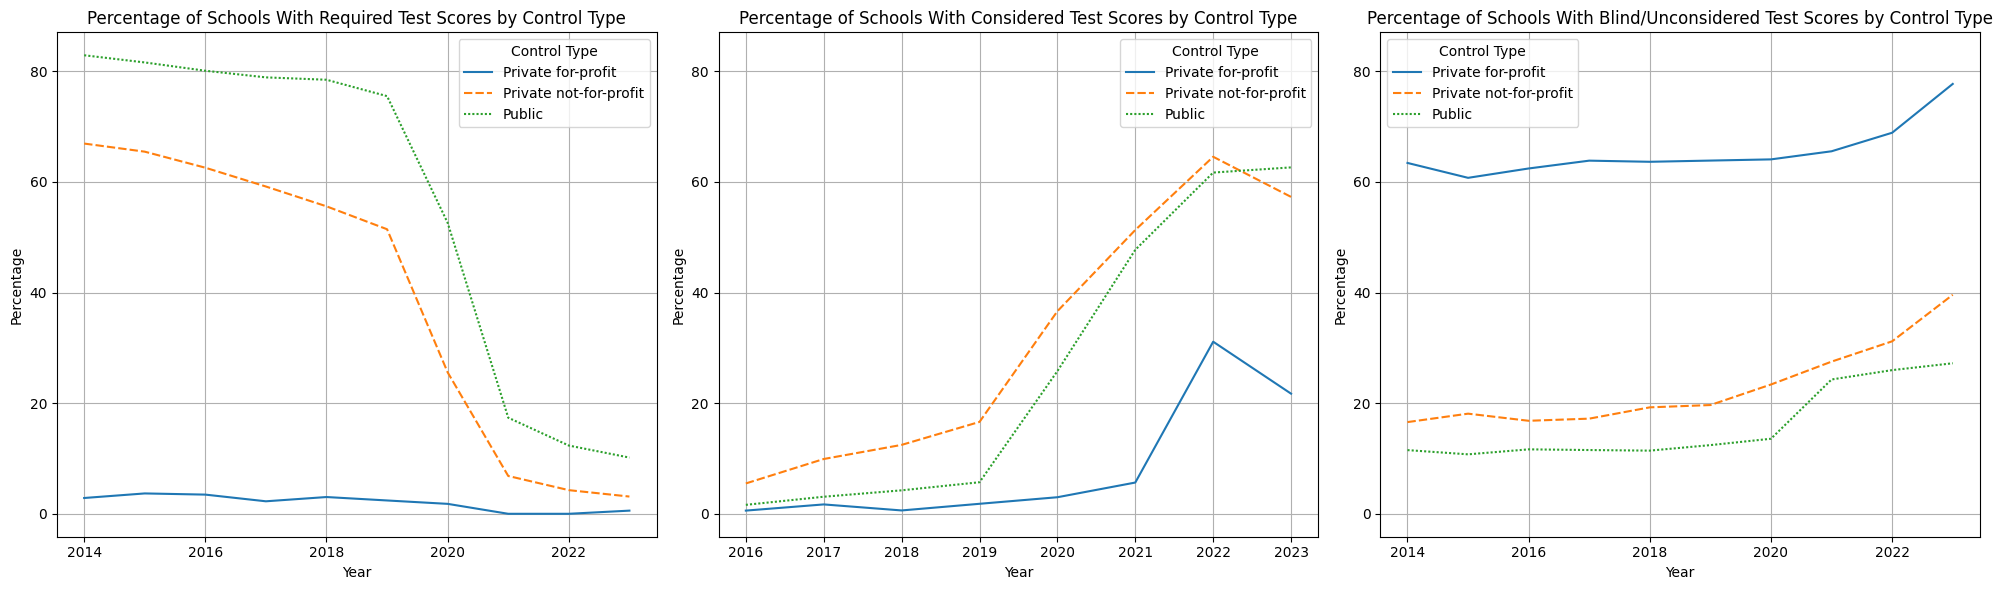

In [15]:
# Define the ADMCON7 values of interest
admcon7_values = {
    1: 'Required',
    5: 'Considered',
    3: 'Blind/Unconsidered'
}

# Create a plot for each ADMCON7 value
plt.figure(figsize=(20, 6)) # Adjusted figure size for horizontal layout

# Get the first axes object to share the y-axis with
ax0 = None

for i, (value, label) in enumerate(admcon7_values.items()):
    if i == 0:
        ax0 = plt.subplot(1, 3, i + 1) # Create the first subplot
    else:
        plt.subplot(1, 3, i + 1, sharey=ax0) # Create subsequent subplots and share the y-axis with the first one

    # Filter data for the current ADMCON7 value
    filtered_df = merged_df[merged_df['ADMCON7'] == value]

    # Calculate the percentage of the current ADMCON7 value by year and CONTROL
    percentage_df = filtered_df.groupby(['year', 'CONTROL']).size().unstack(fill_value=0)
    total_counts = merged_df.groupby(['year', 'CONTROL']).size().unstack(fill_value=0)
    percentage_df = (percentage_df / total_counts) * 100

    # Plot the percentages
    sns.lineplot(data=percentage_df, ax=plt.gca()) # Plot on the current axes
    plt.title(f'Percentage of Schools With {label} Test Scores by Control Type')
    plt.xlabel('Year')
    plt.ylabel('Percentage')
    plt.grid(True)
    plt.legend(title='Control Type')

plt.tight_layout()
plt.savefig('controlXscores.png') # Save the figure as a PNG file
plt.show()

In [16]:
merged_df['is_required'] = (merged_df['ADMCON7'] == 1).astype(int)
merged_df['CONTROL'] = merged_df['CONTROL'].astype('category')
display(merged_df[['ADMCON7', 'is_required', 'CONTROL']].head())

,ADMCON7,is_required,CONTROL
0,1,1,Public
1,1,1,Public
2,1,1,Public
3,1,1,Public
4,1,1,Public


In [17]:
from statsmodels.formula.api import logit

model_formula = 'is_required ~ year + C(CONTROL)'
model = logit(model_formula, data=merged_df).fit()

Optimization terminated successfully.
         Current function value: 0.494088
         Iterations 8


In [18]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:            is_required   No. Observations:                19446
Model:                          Logit   Df Residuals:                    19442
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                  0.2729
Time:                        17:39:51   Log-Likelihood:                -9608.0
converged:                       True   LL-Null:                       -13215.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              880.7031     14.404     61.143      0.000     852.472     908.934
C(CONTROL)[T.Private not-for-profit]     4.0217      

In [19]:
# Examine the p-values for statistical significance
print("P-values for each predictor:")
print(model.pvalues)

# Interpret the coefficients
print("\nInterpretation of Coefficients:")
print(f"Intercept: {model.params['Intercept']:.4f}")
print(f"Coefficient for year: {model.params['year']:.4f}")
print(f"Coefficient for Private not-for-profit (vs Private for-profit): {model.params['C(CONTROL)[T.Private not-for-profit]']:.4f}")
print(f"Coefficient for Public (vs Private for-profit): {model.params['C(CONTROL)[T.Public]']:.4f}")

print("\nStatistical Significance (at alpha=0.05):")
print(model.pvalues < 0.05)

print("\nInterpretation of Coefficients:")
print("The intercept represents the log odds of requiring test scores for the baseline category of CONTROL (Private for-profit) in the year 0 (which is not meaningful in this context, but serves as a reference point).")
print("The coefficient for 'year' is negative and statistically significant, indicating that the log odds of requiring test scores decrease significantly with each passing year.")
print("The coefficient for 'Private not-for-profit' is positive and statistically significant, indicating that holding year constant, the log odds of requiring test scores are significantly higher for Private not-for-profit institutions compared to Private for-profit institutions.")
print("The coefficient for 'Public' is positive and statistically significant, indicating that holding year constant, the log odds of requiring test scores are significantly higher for Public institutions compared to Private for-profit institutions.")
print("Furthermore, the log odds of requiring test scores are higher for Public institutions compared to Private not-for-profit institutions (since the coefficient for Public is larger than the coefficient for Private not-for-profit).")

P-values for each predictor:
Intercept                                0.000000e+00
C(CONTROL)[T.Private not-for-profit]    7.788881e-114
C(CONTROL)[T.Public]                    9.023414e-168
year                                     0.000000e+00
dtype: float64

Interpretation of Coefficients:
Intercept: 880.7031
Coefficient for year: -0.4386
Coefficient for Private not-for-profit (vs Private for-profit): 4.0217
Coefficient for Public (vs Private for-profit): 4.9506

Statistical Significance (at alpha=0.05):
Intercept                               True
C(CONTROL)[T.Private not-for-profit]    True
C(CONTROL)[T.Public]                    True
year                                    True
dtype: bool

Interpretation of Coefficients:
The intercept represents the log odds of requiring test scores for the baseline category of CONTROL (Private for-profit) in the year 0 (which is not meaningful in this context, but serves as a reference point).
The coefficient for 'year' is negative and statistic

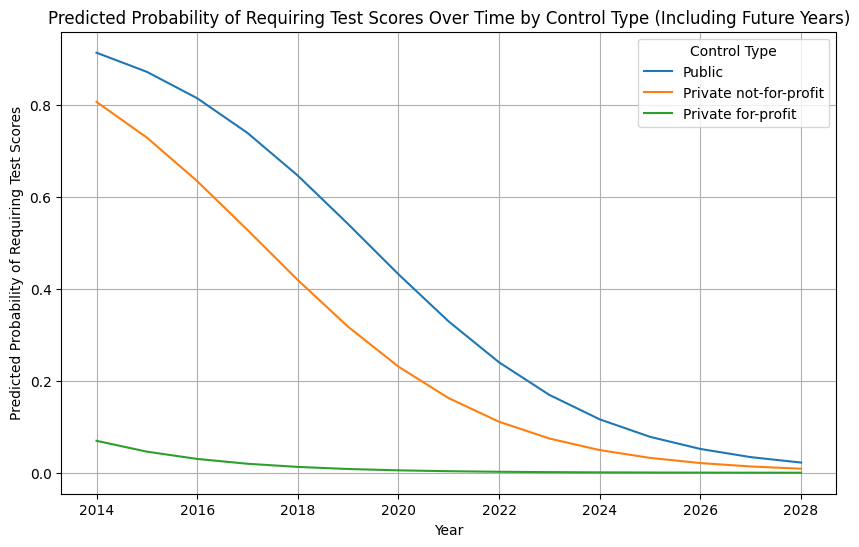

In [22]:
# 1. Generate predicted probabilities
# Create a dataframe with all combinations of years and control types
years = merged_df['year'].unique()
# Add the next 5 years to the years array
future_years = np.arange(years.max() + 1, years.max() + 6)
all_years = np.concatenate((years, future_years))

control_types = merged_df['CONTROL'].unique()
prediction_data = pd.DataFrame([(y, c) for y in all_years for c in control_types], columns=['year', 'CONTROL'])

# Generate predictions
prediction_data['predicted_prob'] = model.predict(prediction_data)

# 2. Create a new DataFrame containing the predicted probabilities, year, and control type (prediction_data is already in this format)

# 3. Plot the predicted probabilities against the year for each control type
plt.figure(figsize=(10, 6))
sns.lineplot(data=prediction_data, x='year', y='predicted_prob', hue='CONTROL')

# 4. Add appropriate labels, a title, and a legend
plt.xlabel('Year')
plt.ylabel('Predicted Probability of Requiring Test Scores')
plt.title('Predicted Probability of Requiring Test Scores Over Time by Control Type (Including Future Years)')
plt.legend(title='Control Type')
plt.grid(True)

# 5. Display the plot
plt.show()